# Time Series 


### Basic

시간에 따른 일련의 데이터를 Time series data라고 합니다. <br>
단 한개의 변수로 이루어진 time series를 **univariate** 이라고 하며, 2개 이상의 변수로 이루어진 time series를 **multivariate**이라고 합니다.


### Trend, Cyclical, Seasonal, Irregular 

Time series는 일반적으로 4개의 요소 (Trend, Cyclical, Seasonal 그리고 Irregular)에 의해 영향을 받습니다.

| Name | Description |
|:-----|:------------|
| **Trend(추세)** |  장기적인 관점에서 봤을때 그래프가 증가하는지, 감소하는지, 또는 정체되어 있는지등의 추세를 Trend라고 합니다.<br>Trend는 따라서 time series안에서 long term movement를 보는 것이 중요합니다. |
| **Seasonality(계절성)** | 특정 구간동안의 (1년, 한달, 일주일..) 변동성(fluctuations)를 나타냅니다. <br>예를 들어서 아이스크림 판매량은 여름에 늘어나고, 외투는 겨운에 판매량이 늘어날 것입니다. 또는 피트니스센터의 고객은 매년 결심을 하는 1월 초에 가장많은 사람들이 나올것입니다. 하지만 매월초가 될수도 있고, 매주초가 될 수도 있습니다. 따라서 피트니스센터는 년, 월, 주단위 seasonality를 갖고 있다고 할수 있습니다. |
| **Cycle(주기)** | Seasonality는 특정 기간에 정확하게 나타나는 변동성을 갖고 있는 반면, Cycle의 경우 특정 시간에 구애 받지 않습니다. 하지만 동일하게 특정 패턴을 갖고 있습니다. 보통 2~3년처럼 장기간에 걸친 패턴을 갖고 있을수 있습니다. 예를 들어서 business cycle의 경우에는 호황 -> 불황 -> 침체 -> 회복 의 cycle을 갖고 있습니다. | 
| **Irregularity(불규칙성)** | 또는 random variations이라고 불리며 예상치 못한 영향에 의해서 나타납니다. 예를 들어서 전쟁, 지진, 홍수, 혁명등등이 될 수 있습니다. |



# Import

In [1]:
%pylab inline
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data

아래의 링크에서 데이터를 다운받을 수 있습니다.<br>
[Daily minimum temperatures in Melbourne, Australia, 1981-1990](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line)

[Header]
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

Train Size: (3600, 1)
Test Size : (50, 1)


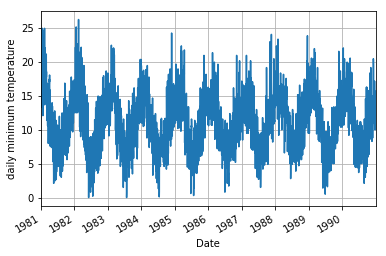

In [2]:
TEST_SIZE = 50

_filename= '/dataset/daily-minimum-temperature-in-melbourne/daily-minimum-temperatures-in-me.csv'
dataframe = pd.Series.from_csv(_filename, header=0)
dataframe.index = dataframe.index.to_datetime()
dataframe = dataframe.astype('float64')
print('[Header]')
print(dataframe.head())
dataframe.plot(grid=True)
ylabel('daily minimum temperature')

# Normalization 
scaler = MinMaxScaler()
data = scaler.fit_transform(dataframe.values.reshape((-1, 1)))

# Split Training and Test Data
train, test = data[:-TEST_SIZE], data[-TEST_SIZE:]
# train, test = train_test_split(data, test_size=0.1)
# train_data, test_data = data[0:len(data)-7], data[len(data)-7:]
print()
print('Train Size:', train.shape)
print('Test Size :', test.shape)

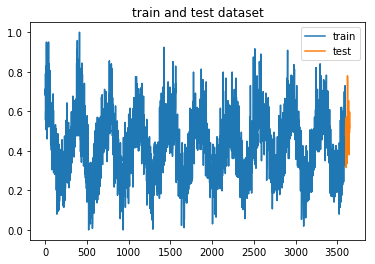

In [3]:
plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

            passenger
1949-01-01      112.0
1949-02-01      118.0
1949-03-01      132.0
1949-04-01      129.0
1949-05-01      121.0


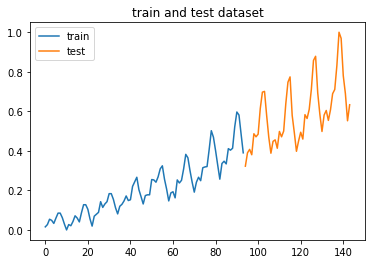

In [4]:
dataframe = pd.read_csv('/dataset/time-series/international-airline-passengers/international-airline-passengers.csv', 
                   names=[ 'passenger'], index_col=0,
                   skiprows=1)
dataframe.index = pd.to_datetime(dataframe.index)
dataframe = dataframe.astype('float64')
print(dataframe.head())

scaler = MinMaxScaler()
data = scaler.fit_transform(dataframe.values.reshape((-1, 1)))

train, test = data[:-TEST_SIZE], data[-TEST_SIZE:]

plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

# Autocorrelation Checking

Autoregression은 이전의 time-steps의 observations을 통해 다음 step의 값을 예측하는데 사용될 수 있다는 가정을 갖고 있습니다.<br>
variables관의 관계를 correlation이라고 하며, 두 variables이 동시에 증가하거나 감소하면 **positive correlation**이라고 하며, 서로 반대방향으로 움직인다면 (하나는 증가하고, 하나는 감소하는 상황.) **negative correlation**이라고 합니다.

output variable (예측값) 그리고 이전 time-steps의 값(lagged variables)들의 correlation을 구함으로서 통계적 측정을 할 수 있습니다.<br>
correlation을 통해서 얼마만큼의 lag variables을 사용해야될지 알 수 있으며, 그래프가 predictable한지 안 한지도 알 수 있습니다.

> Autocorrelation에서 auto가 붙는 이유는 위에서 설명했듯이, 자기자신(auto or self)의 데이터를 사용하여 자기 자신의 데이터를 예측하기 때문에 이렇게 이름이 지어졌습니다.



### Lag Plot 

빠르게 correlation이 존재하는지 확인하는 방법은 step t 와 t-1 을 scatter plot으로 그래서 확인하는 방법입니다.<br>
집접 데이터를 가공해서 만들수도 있지만, Pandas에서는 lag_plot이라는 함수를 통해서 쉽게 lag plot을 그려볼 수 있습니다.


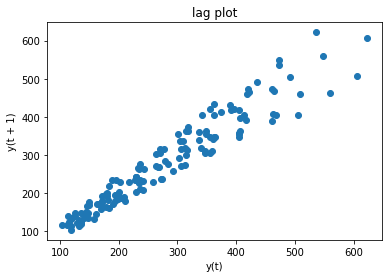

In [5]:
lag_plot(dataframe, lag=1)
title('lag plot')

step t 와 step t-1 의 관계가 전혀 없는 random한 상황속에서는 다음과 같이 그래프가 그려집니다.

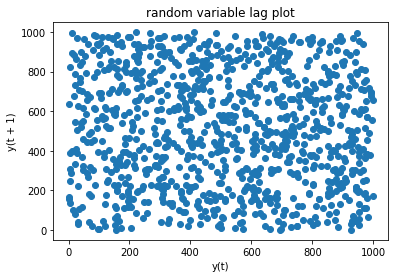

In [6]:
series = pd.Series([np.random.randint(0, 1000) for _ in range(1000)])
lag_plot(series)
title('random variable lag plot')

### Pearson Correlation Coefficient

t-1 과 t의 상관관계를 pearson correlation으로 구할수 있습니다. <br>

* negative correlated: -1 
* positive correlated: 1
* correlation: 0.5보다 크거나, -0.5보다 작을시 높은 correlation

아래의 예제에서는 0.77487의 correlation값을 보이는데 positive correlated이며 correlation이 높다고 할 수 있습니다.

In [7]:
data2 = pd.concat([dataframe.shift(2), dataframe.shift(1), dataframe], axis=1)
data2.columns = ['t-2', 't-1', 't']
data2.corr()

,t-2,t-1,t
t-2,1.000000,0.960249,0.895675
t-1,0.960249,1.000000,0.960195
t,0.895675,0.960195,1.000000


### Autocorrelation Plot

각각의 lag variable에 대한 correlation을 plotting할 수 도 있지만, Pandas에서 이미 지원해주고 있습니다.

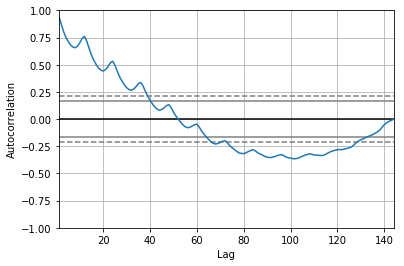

In [8]:
autocorrelation_plot(data)

statsmodel 라이브러리에서 제공하는 plot_acf를 사용할수도 있습니다.

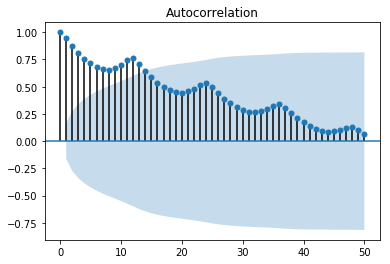

In [9]:
plot_acf(data, lags=50)
print(end='')

Random variable의 경우에는 다음과 같이 전혀 맞지 않게 나옵니다.

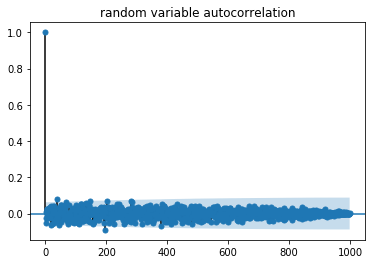

In [10]:
series = pd.Series([np.random.randint(0, 1000) for _ in range(1000)])
plot_acf(series, title='random variable autocorrelation')
print()

# Lag Operator

Lag Operator $ L $ 또는 Backshift $ B $ 로 표현을 하며 시계열상의 과거의 데이터를 설명할때 사용합니다.

$$ \begin{align} 
Ly_t &= y_{t-1} \\
y_t &= Ly_{t+1} \\
\end{align} $$

이때 Lag Operator $ L $ 은 여러가지 정수값으로 제곱이 될 수 있습니다.

$$ \begin{align} 
L^ky_t &= y_{t-k} \\
L^{-1}y_t &= y_{t+1} \\
L^2y_t &= y_{t-2} \\
\end{align}$$

### Lag Polynomials

$ a(L) $ 를 lag polynomials 로 정의한다면 다음과 같습니다.

$$ a(L) = a_0 + a_1L + ... + a_pL^p $$

위의 공식은 operator로서 사용이 될 수 있습니다.

$$ a(L)x_t = a_0x_t + a_1x_{t-1} + .. + a_p x_{t-p} $$

lag polynomials는 더하거나 곱하는 연산을 할 수도 있습니다. <br>
예를 들어서 만약 $ a(L) = (1-aL) $ 이고 $ b(L) = (1-bL) $ 이라면 

$$ \begin{align} 
a(L)b(L)x_t &=  (1-aL)(1-bL)x_t \\
  &= (1-aL)(x_t - bx_{t-1}) \\
  &= x_t - bx_{t-1} - aL(x_t - bx_{t-1}) \\
  &= x_t - bx_{t-1} - a(x_{t-1} - bx_{t-2}) \\
  &= x_t - bx_{t-1} - ax_{t-1} + abx_{t-2} \\
  &= x_t -(a+b)x_{t-1} + abx_{t-2} \\
  &= \left( 1 - (a+b)L + abL^2 \right) x_t
\end{align} $$

### Invert 

lag polymials 는 inverted될 수 있습니다. 

$$ (1-pL)(1-pL)^{-1} = \frac{(1-pL)}{(1-pL)} = 1 $$


### Difference Operator 

Time series 분석에서 first difference operator $ \Delta $ 는 lag polynomial의 특별한 케이스입니다.

$$ \begin{align} 
\Delta X_t &= X_t - X_{t-1} \\
\Delta X_t &= (1 - L)X_t \\
\end{align} $$

유사하게 second difference operator는 다음과 같습니다.

$$ \begin{align} 
\Delta(\Delta X_t) &= \Delta X_t - \Delta X_{t-1} \\
  \Delta^2 X_t &= (1 - L) \Delta X_t \\
  \Delta^2 X_t &= (1-L)(1-L) X_t \\
  \Delta^2 X_t &= (1-L)^2 X_t
\end{align} $$

위의 공식은 다음과 같이 일반화 될 수 있습니다.

$$ \Delta^i X_i = (1-L)^i X_t $$

Seconds Difference의 예제는 다음과 같습니다.

| Original Sequence | 0  |    | 1  |    | 4  |    | 9  |    | 16 |    | 25 |    | 36 |
|:------------------|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| First Difference  |    | 1  |    | 3  |    | 5  |    | 7  |    | 9  |    | 11 |    |
| Second Difference |    |    | 2  |    | 2  |    | 2  |    | 2  |    | 2  |    |&nbsp;|


# AR (Autoregressive) Model

AR(p) (AutoRegressive of order p)는 간단하게 과거의 패턴이 지속된다면 <br>
시계열 데이터 관측치 $ y_t $ 는 과거 관측치 $ y_{t-1} $, $ y_{t-2} $, $ y_{t-3} $, ... 에 의해 예측될 수 있다고 봅니다. <br>
오직 과거의 데이터(lagged variables)만 사용해서 예측 모형을 만들게 되며, 이름도 autoregressive 입니다. (그리스어로 auto 라는 뜻은 "self"를 가르킵니다.)<br>



$$ \begin{align}
X_t &= \alpha_1 X_{t-1} + ... + \alpha_p X_{t-p} + \epsilon_t + c  \\
&= c + \sum^p_{i=1} \alpha_i X_{t-i} + \epsilon_t
\end{align}$$ 

* **order:** $ p $
* **parameters (coefficients):** $ \alpha_1 $, $ \alpha_2 $, ..., $ \alpha_p $
* **error term (white noise):** $ \epsilon_t $

즉 time lag operator를 사용하면 다음과 같이 공식을 세울 수 있습니다.<br>
그리고 아래의 notation은 ARMA (autoregressive moving average)와 동일합니다.

$$ \left( 1 - \sum^p_{k=1} \alpha_k L^k \right) X_t = \epsilon_t $$

이때 다음과 같은 조건들을 갖습니다.

$$ \begin{align} 
|\alpha| &< 1 \\
Var[X_t] &= \frac{\sigma^2}{1-\sigma^2}
\end{align} $$

## Code Example

statsmodel에서 제공하는 AR 을 사용하면 Autoregressive Model을 구현할 수 있습니다.<br>
문제는 해당 라이브러리가 학습된 부분에서 예측을 하면 잘되나, forecast를 하려고 하면 잘 나오지를 않습니다. <br>
이는 라이브러리가 학습했었던 데이터 자체를 갖고 있고, 이것을 토대로 하여 예측을 하기 때문에, 학습 데이터의 범위를 넘어서 예측을 하려고 하면 잘 되지를 않습니다. 

Lag: 12
Params: [ 0.01898271  0.48485522 -0.25494785  0.182324   -0.20208175  0.20946825
 -0.12631762  0.09739854 -0.19255776  0.20917163 -0.20369166  0.34405421
  0.55972614]
R^2 Score: 0.830431464963


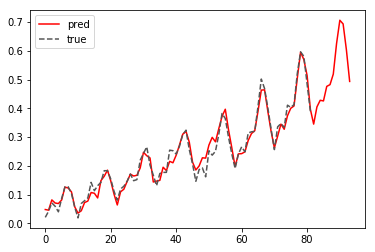

In [33]:
PRED_N = 300
model = AR(train)
model = model.fit(disp=True)

pred = model.predict(start=model.k_ar, end=len(train)+model.k_ar-1)

plot(pred, label='pred', color='red')
plot(train[model.k_ar:], linestyle="--", label='true', color="#555555")
legend()

print('Lag:', model.k_ar)
print('Params:', model.params)
print('R^2 Score:', r2_score(pred, train))

! 학습된 데이터의 범위를 넘어서 forecast를 하려고 하면 작동하지 않습니다. (이유는 계속 설명)

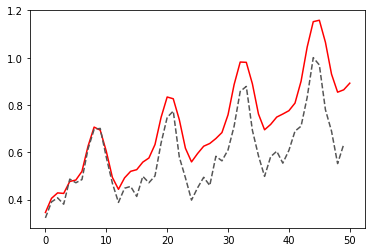

In [27]:
pred = model.predict(start=len(train), end=len(train)+len(test))
plot(pred, color='red')
plot(test, linestyle="--", color="#555555")

Forecast를 해주기 위해서 따로 함수를 만들었습니다.<br>
언뜻보면 매우 잘 돌아가는 것 처럼 보이지만, Autoregressive Model은 예측된 값으로 다시 예측을 하는 것이 아니라 t+1 의 값을 예측한뒤, t+1에는 실제값을 lags에 넣어서 다시 그 다음 t+2를 예측 합니다. 
즉 Autoregressive Model자체가 t+1 이상의 예측을 제대로 해낼수 없음을 말합니다.

prediction shape: (50,)
test shape      : (50, 1)
R^2 Score: 0.128437850786


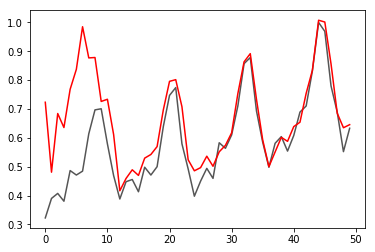

In [28]:
def forecast(model, data, n, real=False):
    window = model.k_ar
    c = model.params[0]
    coefs = model.params[1:]
    
    lags = data[-window:].reshape(-1)
    preds = list()
    
    for i in range(n):
        lags = lags[-window:]
        
        next_v = np.sum(lags[::-1] * coefs) + c
        if real:
            lags = np.append(lags, next_v) # 예측된 값 자체를 lags로 집어 넣는다. 
        else:
            lags = np.append(lags, data[i]) # true데이터를 lags로 집어 넣는다.
        preds.append(next_v)
        
    return np.array(preds)
    
    
pred = forecast(model, test, n=len(test), real=False)
print('prediction shape:', pred.shape)
print('test shape      :', test.shape)
print('R^2 Score:', r2_score(pred, test))
plot(test, color='#555555')
plot(pred, color='red')

예측된 값으로 다시 예측을 시도할시.. 예측률이 -46까지 떨어집니다.

prediction shape: (50,)
test shape      : (50, 1)
R^2 Score: -3.2181543123


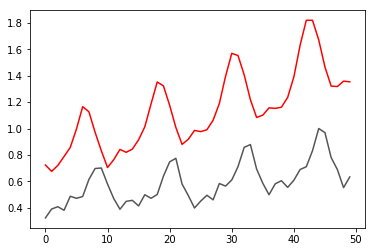

In [29]:
pred = forecast(model, test, n=len(test), real=True)
print('prediction shape:', pred.shape)
print('test shape      :', test.shape)
print('R^2 Score:', r2_score(pred, test))
plot(test, color='#555555')
plot(pred, color='red')

정말로 예측을 t+1밖에 못하는것인지.. 구현이 동일한지 확인을 하였습니다. <br>
결과적으로 r^2 score가 1값이 나오면서 제가 만든 구현이 라이브러리에서 제공하는 것과 동일하며, Autoregressive Model은 t+1밖에 forecast를 못합니다. 즉.. 못한다는 뜻은 예측값으로 다시 예측을 하는 것이 아니라, t+1을 예측후, t+1 = 실제값 을 넣어서 다시 예측을 하기 때문에 진정한 의미의 forecast를 하는것은 아닙니다.

> 통계학 전공하시는 분께 물어보니.. **ARIMA나 이런 계열의 모델 자체가 대략 7일정도밖에 예측을 못한다고 합니다.** <br>
> 그 이후는 평균값에 convergence되버린다고 합니다. <br>
> 따라서 ARIMA 모델같은 것으로 장기적인 예측을 하는 것은 적합하지가 않습니다.<br>
> 통계적으로 더 잘 예측하기 위해서는 더 복잡한 예측 모델을 써야하는데.. 문제는 더 복잡해질수록.. 분석가들의 손길이 더 간다는것.. <br>
> 중간 결론적으로는 그냥 LSTM쓰는게 더 좋네요. 

R^2 Score: 1.0


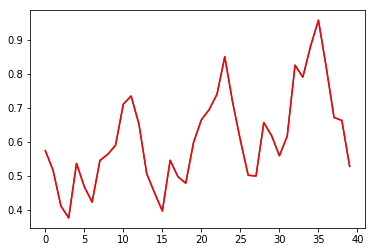

In [15]:
model2 = AR(test)
model2 = model2.fit(disp=True)
pred1 = model2.predict(start=model2.k_ar, end=len(test)+model2.k_ar-1)
pred2 = forecast(model2, test, n=len(test), real=False)

# 내가 만든 forecast와 predict의 구현 차이가 조금 있다. 하지만 결과는 동일하다
pred1 = pred1[:-model2.k_ar]
pred2 = pred2[model2.k_ar:]

print('R^2 Score:', r2_score(pred1, pred2))
plot(pred1, color="#555555")
plot(pred2, color='red')

# Moving Average Model

Moving-average Model은 univariate time series를 모델링 하는데 사용되는 방법중의 하나입니다. <br>
AR Model과 함께 ARMA 그리고 ARIMA 모델의 중요 컴포넌트가 됩니다.<br>

> Moving Average Model은 Moving Average와 전혀 다릅니다.<br>
> 또한 AR과 다르게 MA는 항상 stationary 입니다.

### Definition

Moving Average with orders p and q 모델은 noise에 관하여 $ X_t $에 대해 다음과 같이 정의를 하고 있습니다.

$$ X_t = \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q} $$

noise 의 (weighted)평균으로 구해지지만 전체 시간을 모두 구하는 것이 아니라, average moving $ t $ 그리고 $ q+1 $ times가 사용됩니다.<br>
time lags를 사용하여 다음과 같이 정의 할 수 있습니다.

$$ X_t = \left(1 + \sum^q_{k=1} \beta_k L^k \right) \epsilon_t $$

# ARMA (AutoRegressive Moving Average) Model

ARMA(p, q) (AutoRegressive Moving Average with orders p and q) 는 AR(p) 와 MA(q) 를 합친 모델이며, univariate time series 모델링에 적합합니다.<br>
미래의 값은.. 과거 p 관측치 그리고 random error를 합친 것으로 여깁니다.

$$ \left( 1 - \sum^p_{k=1} \alpha_k L^k \right) X_t = \left( 1 + \sum^q_{k=1} \beta_k L^k \right) \epsilon_t $$

풀어쓰면 다음과 같습니다.

$$ X_t = \alpha_1 X_{t-1} + ... + \alpha_p X_{t-p} + \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q} $$

### ARMA 코드 구현

Python from statsmodels.tsa.arima_model 안의 ARMA 를 사용해서 구현할수 있습니다. <br>
사용되는 공식은 다음과 같습니다.

![alt text](images/arma.jpg " jaja")

statsmodels.tsa.arima_model.ARMA 를 사용할수 있으며 다음과 같이 parameters를 사용할 수 있습니다.

```
ARMA(endog, order, exog=None, dates=None, freq=None, missing='none')
---------------------------------------------------------------------
endog : array-like
    The endogenous variable.
order : iterable
    The (p,q) order of the model for the number of AR parameters,
    differences, and MA parameters to use.
```

In [16]:
arma = ARMA(train, (29, 5))
arma.

SyntaxError: invalid syntax (<ipython-input-16-583f47ae12f3>, line 2)

# Auto-Regressive Integrated Moving Average (ARIMA)

ARIMA를 적용하기 위해서는 time series는 linear 하며 통계적 분포(normal distribution같은 statistical distribution)을 따른다고 가정합니다. <br>
다음의 모델들의 특징을 모두 갖고 있습니다.

* Autoregressive (AR)
* Moving Average (MA)

# References 

* https://gejza.nipax.cz/_media/stochasticke_procesy:1302.6613.pdf
* http://www.uh.edu/~bsorense/arma-intro2012.pdf
* http://users.dma.unipi.it/~flandoli/AUTCap4.pdf
* https://en.wikipedia.org/wiki/Lag_operator
* http://homepage.stat.uiowa.edu/~rdecook/stat2020/notes/ch5_pt1.pdf
* http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016